This notebook contains SOTIP's spatial domain identification module using a Visium cortex dataset. For the steps, please refer to the table of contents automatically generated by jupyterlab on the left side bar.

author: Zhiyuan Yuan

# imports

In [3]:
from sotip import *
import numpy as np
import scanpy as sc


# data loading and processing steps

### load data

In [4]:
# this data is derived from the original osmFISH nature methods paper
# please refer to our supplementary table 1 for more data details
adata = sc.read_h5ad('../data/151673.h5ad')

### process the data with scanpy routine

In [5]:
sc.pp.pca(adata,n_comps=50)
sc.pp.neighbors(adata,n_neighbors=100)
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=2)

### plot clustering result

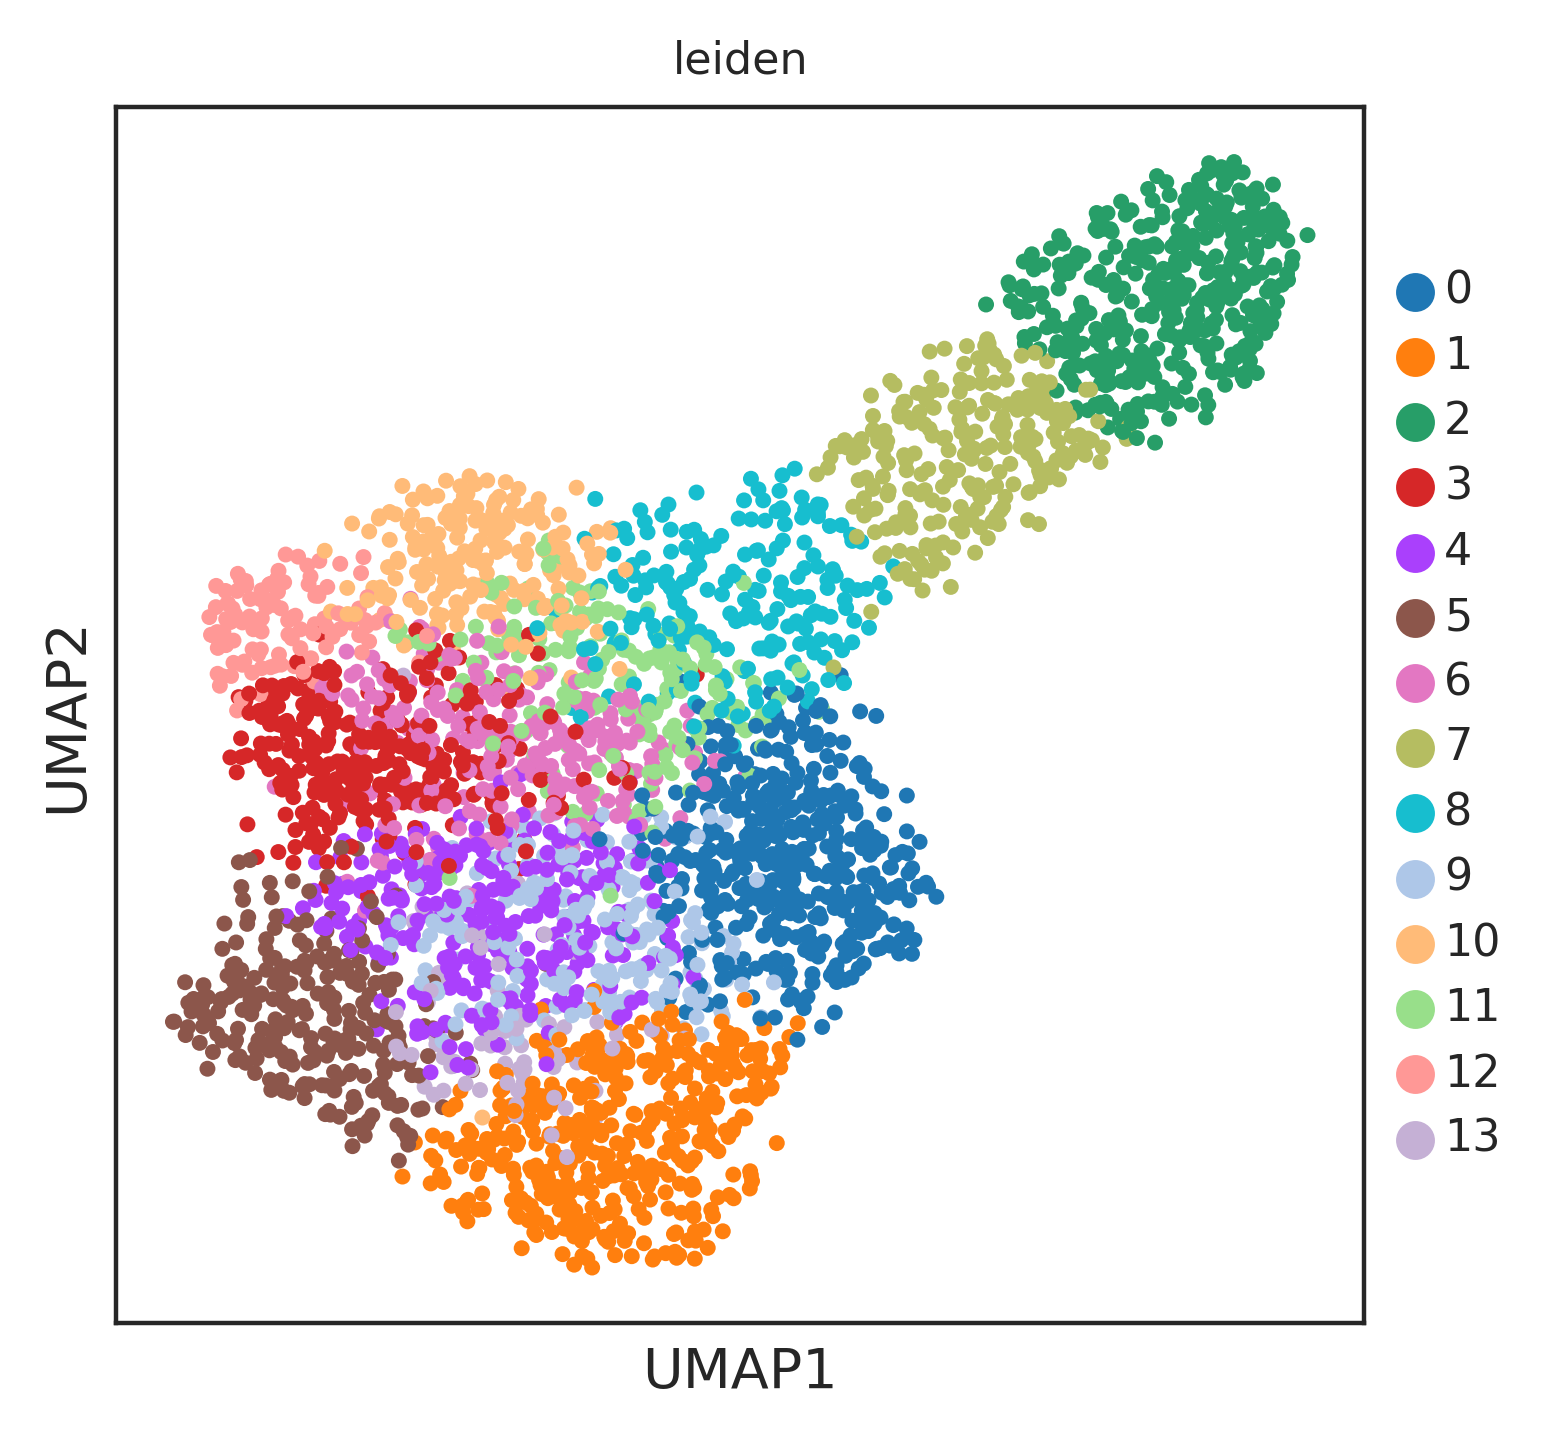

In [6]:
sc.pl.umap(adata,color=['leiden'])

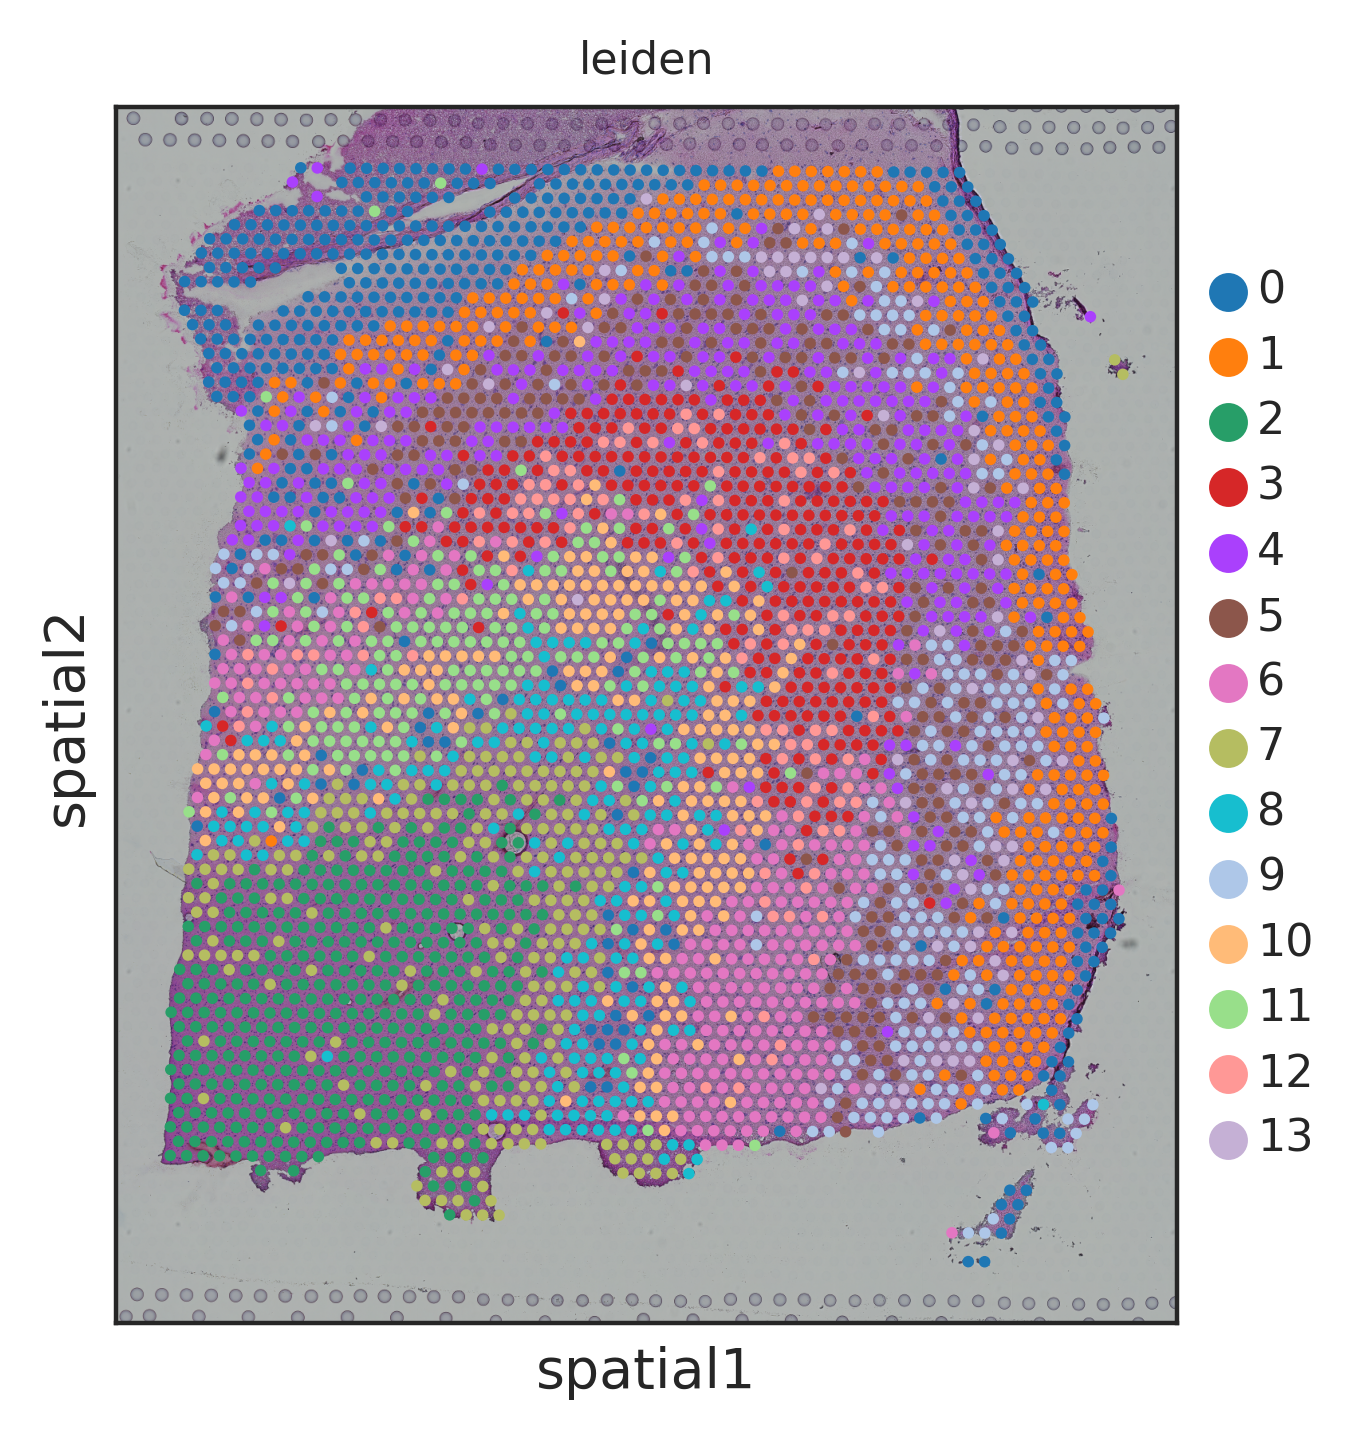

In [7]:
sc.pl.spatial(adata,color=['leiden'],marker='h')

# SOTIP steps

### step 1: each ME is associated with its center cell

In [8]:
# ME size 
knn = 10

# spatial coordination used for ME
spatial_var='spatial'

# cluster label used for ME
cls_key='leiden'

# order of cluster label for ME representation (adata.obsm['ME'])
ME_var_names_np_unique = np.array(adata.obs[cls_key].cat.categories) 

# this function added a ME obsm for adata
MED(adata,use_cls=cls_key,nn=knn,copy=False,ME_var_names_np_unique=ME_var_names_np_unique,spatial_var=spatial_var) 


knn search time cost 0.009434700012207031 s
0 MEs,time cost 1.9073486328125e-06 s, 3639 MEs, 6.940841674804687e-06s left
1000 MEs,time cost 0.17174506187438965 s, 2639 MEs, 0.4532352182865143s left
2000 MEs,time cost 0.16815996170043945 s, 1639 MEs, 0.27561417722702025s left
3000 MEs,time cost 0.1414961814880371 s, 639 MEs, 0.09041605997085571s left


array([[ 0.,  1.,  0., ...,  0.,  0.,  2.],
       [10.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 10., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  3., ...,  0.,  0.,  0.],
       [ 1.,  8.,  0., ...,  0.,  0.,  0.]])

In [9]:
# the resulted ME representation is a n*k vector
# n is the number of MEs (cells), k is the number of unique cell clusters
# the i,jth element of the representation is defined as the frequency of cell type_j in ME_i
adata.obsm['ME'].shape

(3639, 14)

### step 2: Connectivity guided minimum graph distance (CGMGD)

#### step 2.1 topological structure is computed with paga

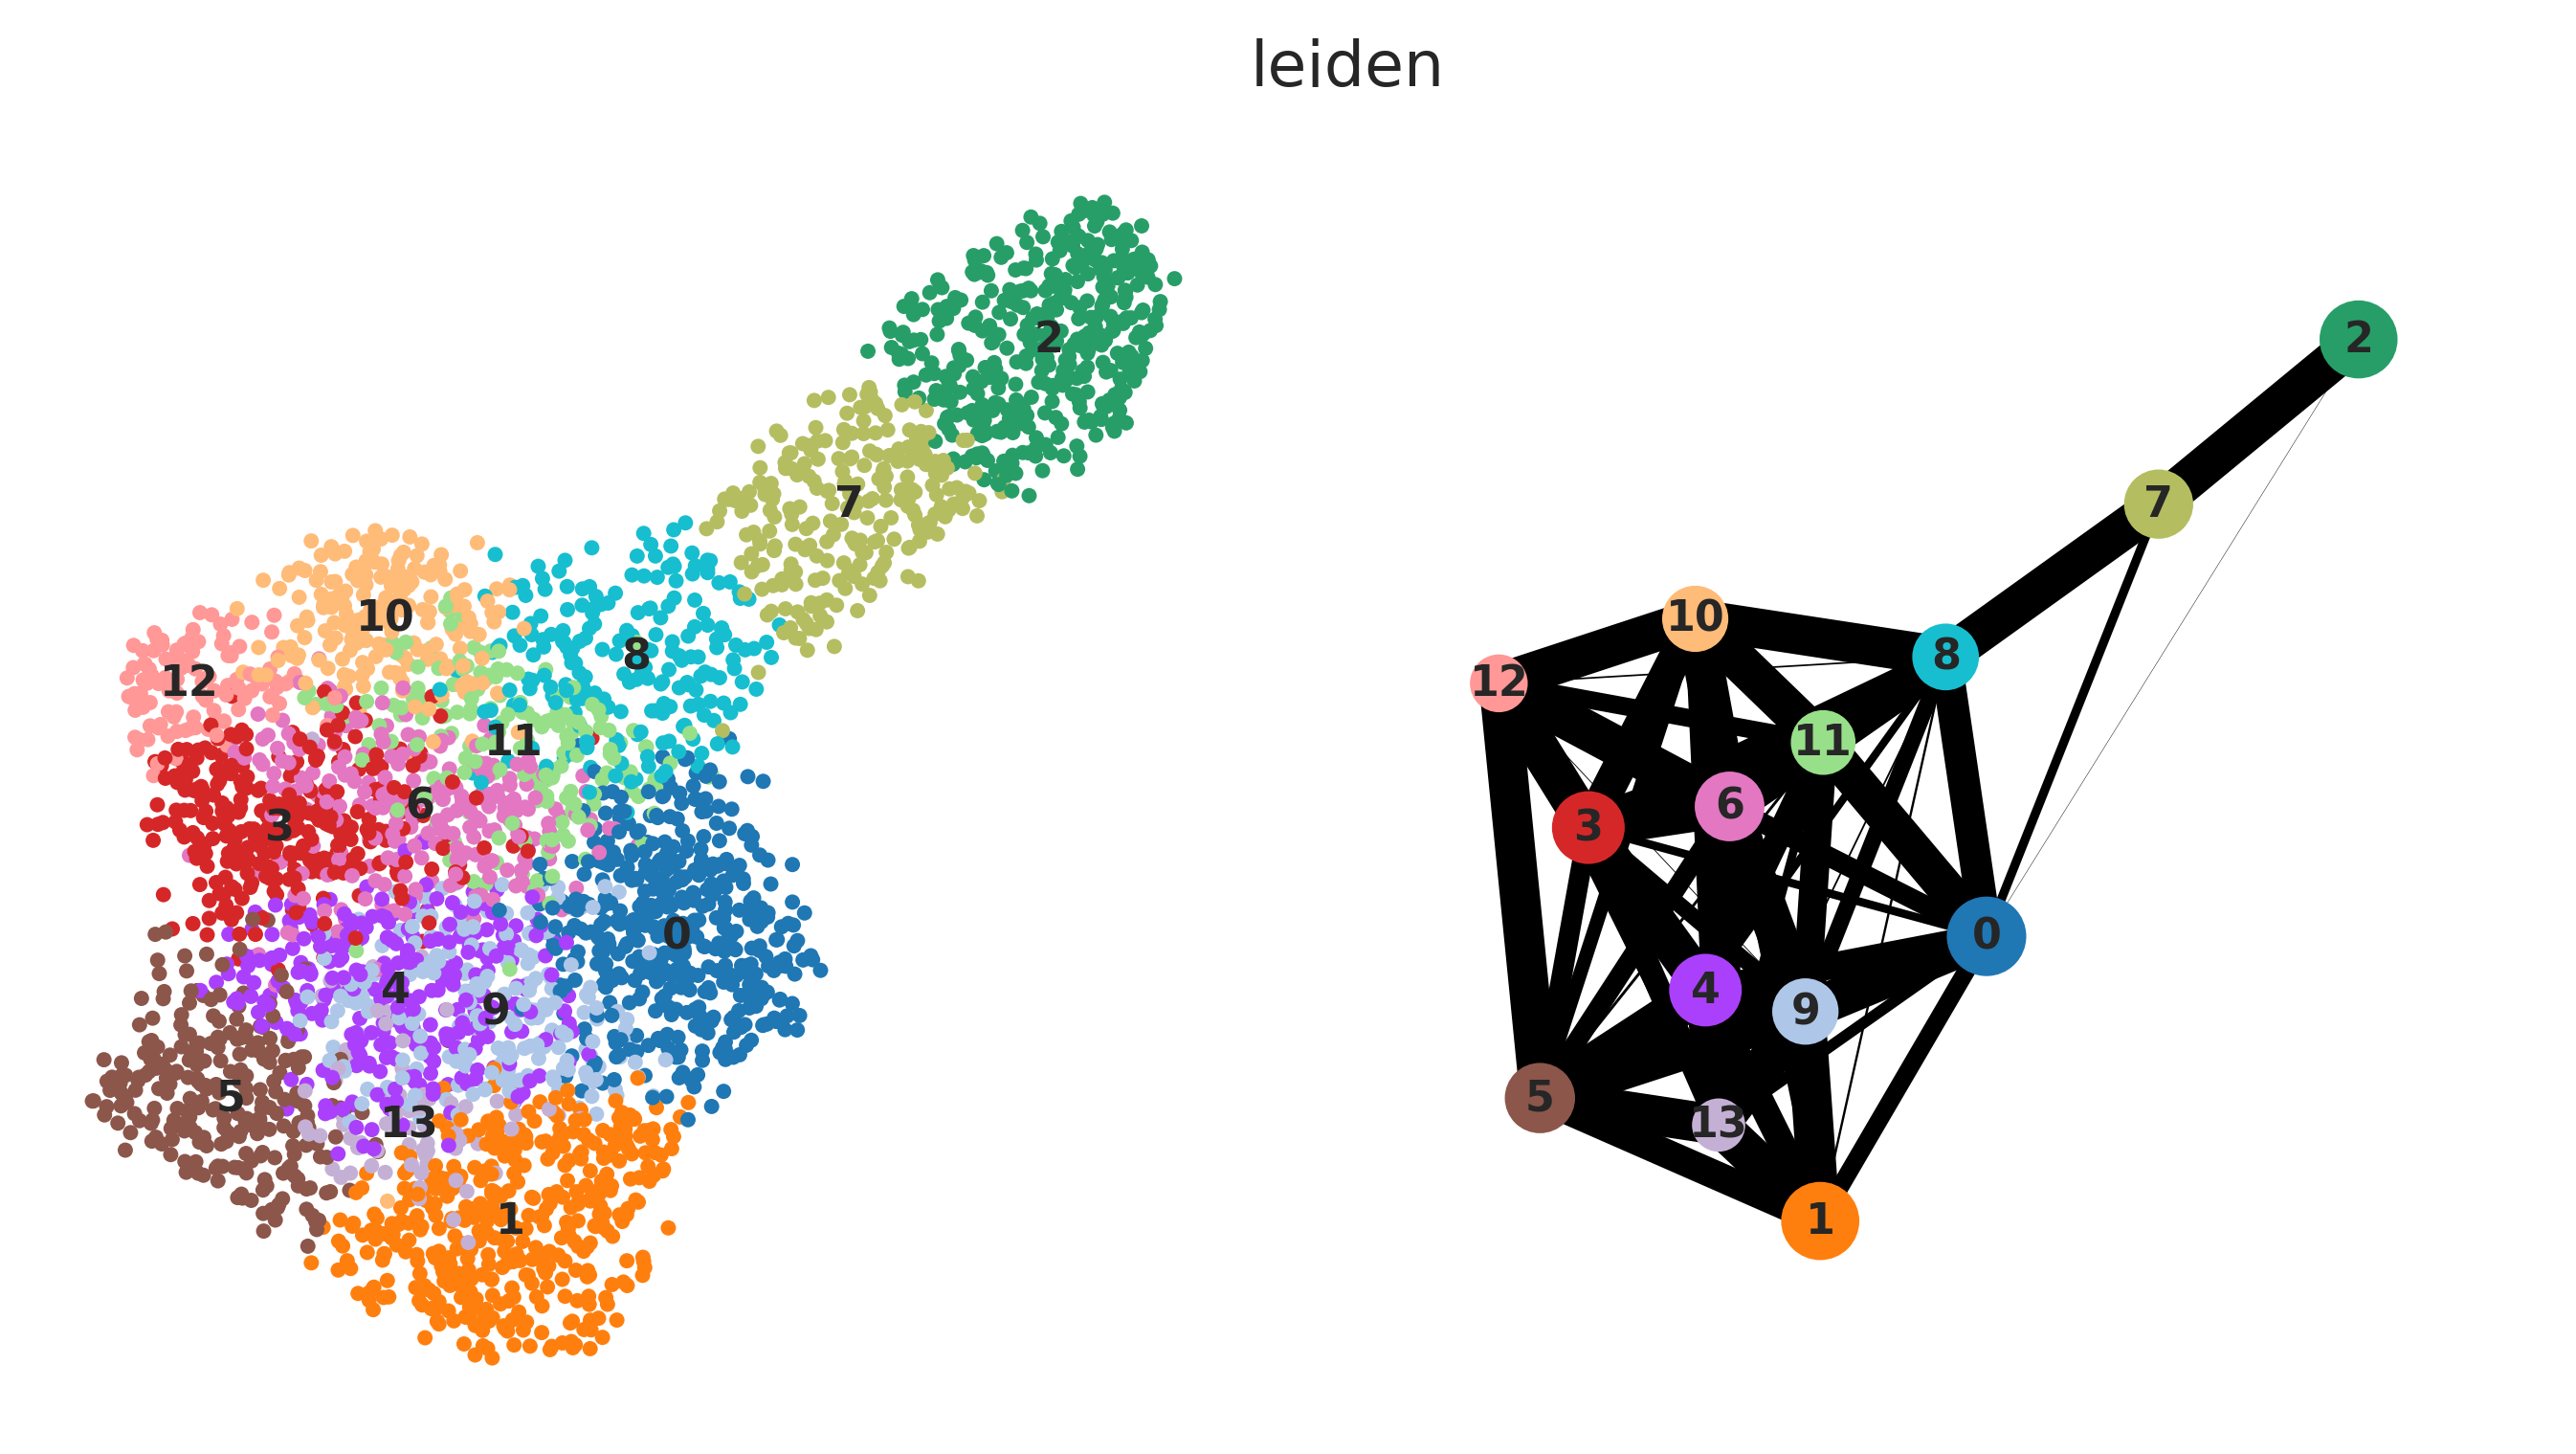

In [10]:
cls_key = 'leiden'
sc.tl.paga(adata,groups=cls_key)
sc.pl.paga_compare(adata,basis='X_umap')

#### step 2.2 the connectivities between cell clusters is used to guide the graph distance computation

In [11]:
gd_method = 'paga_guided_umap'
gd = get_ground_distance(adata,method=gd_method,cls_key=cls_key)  


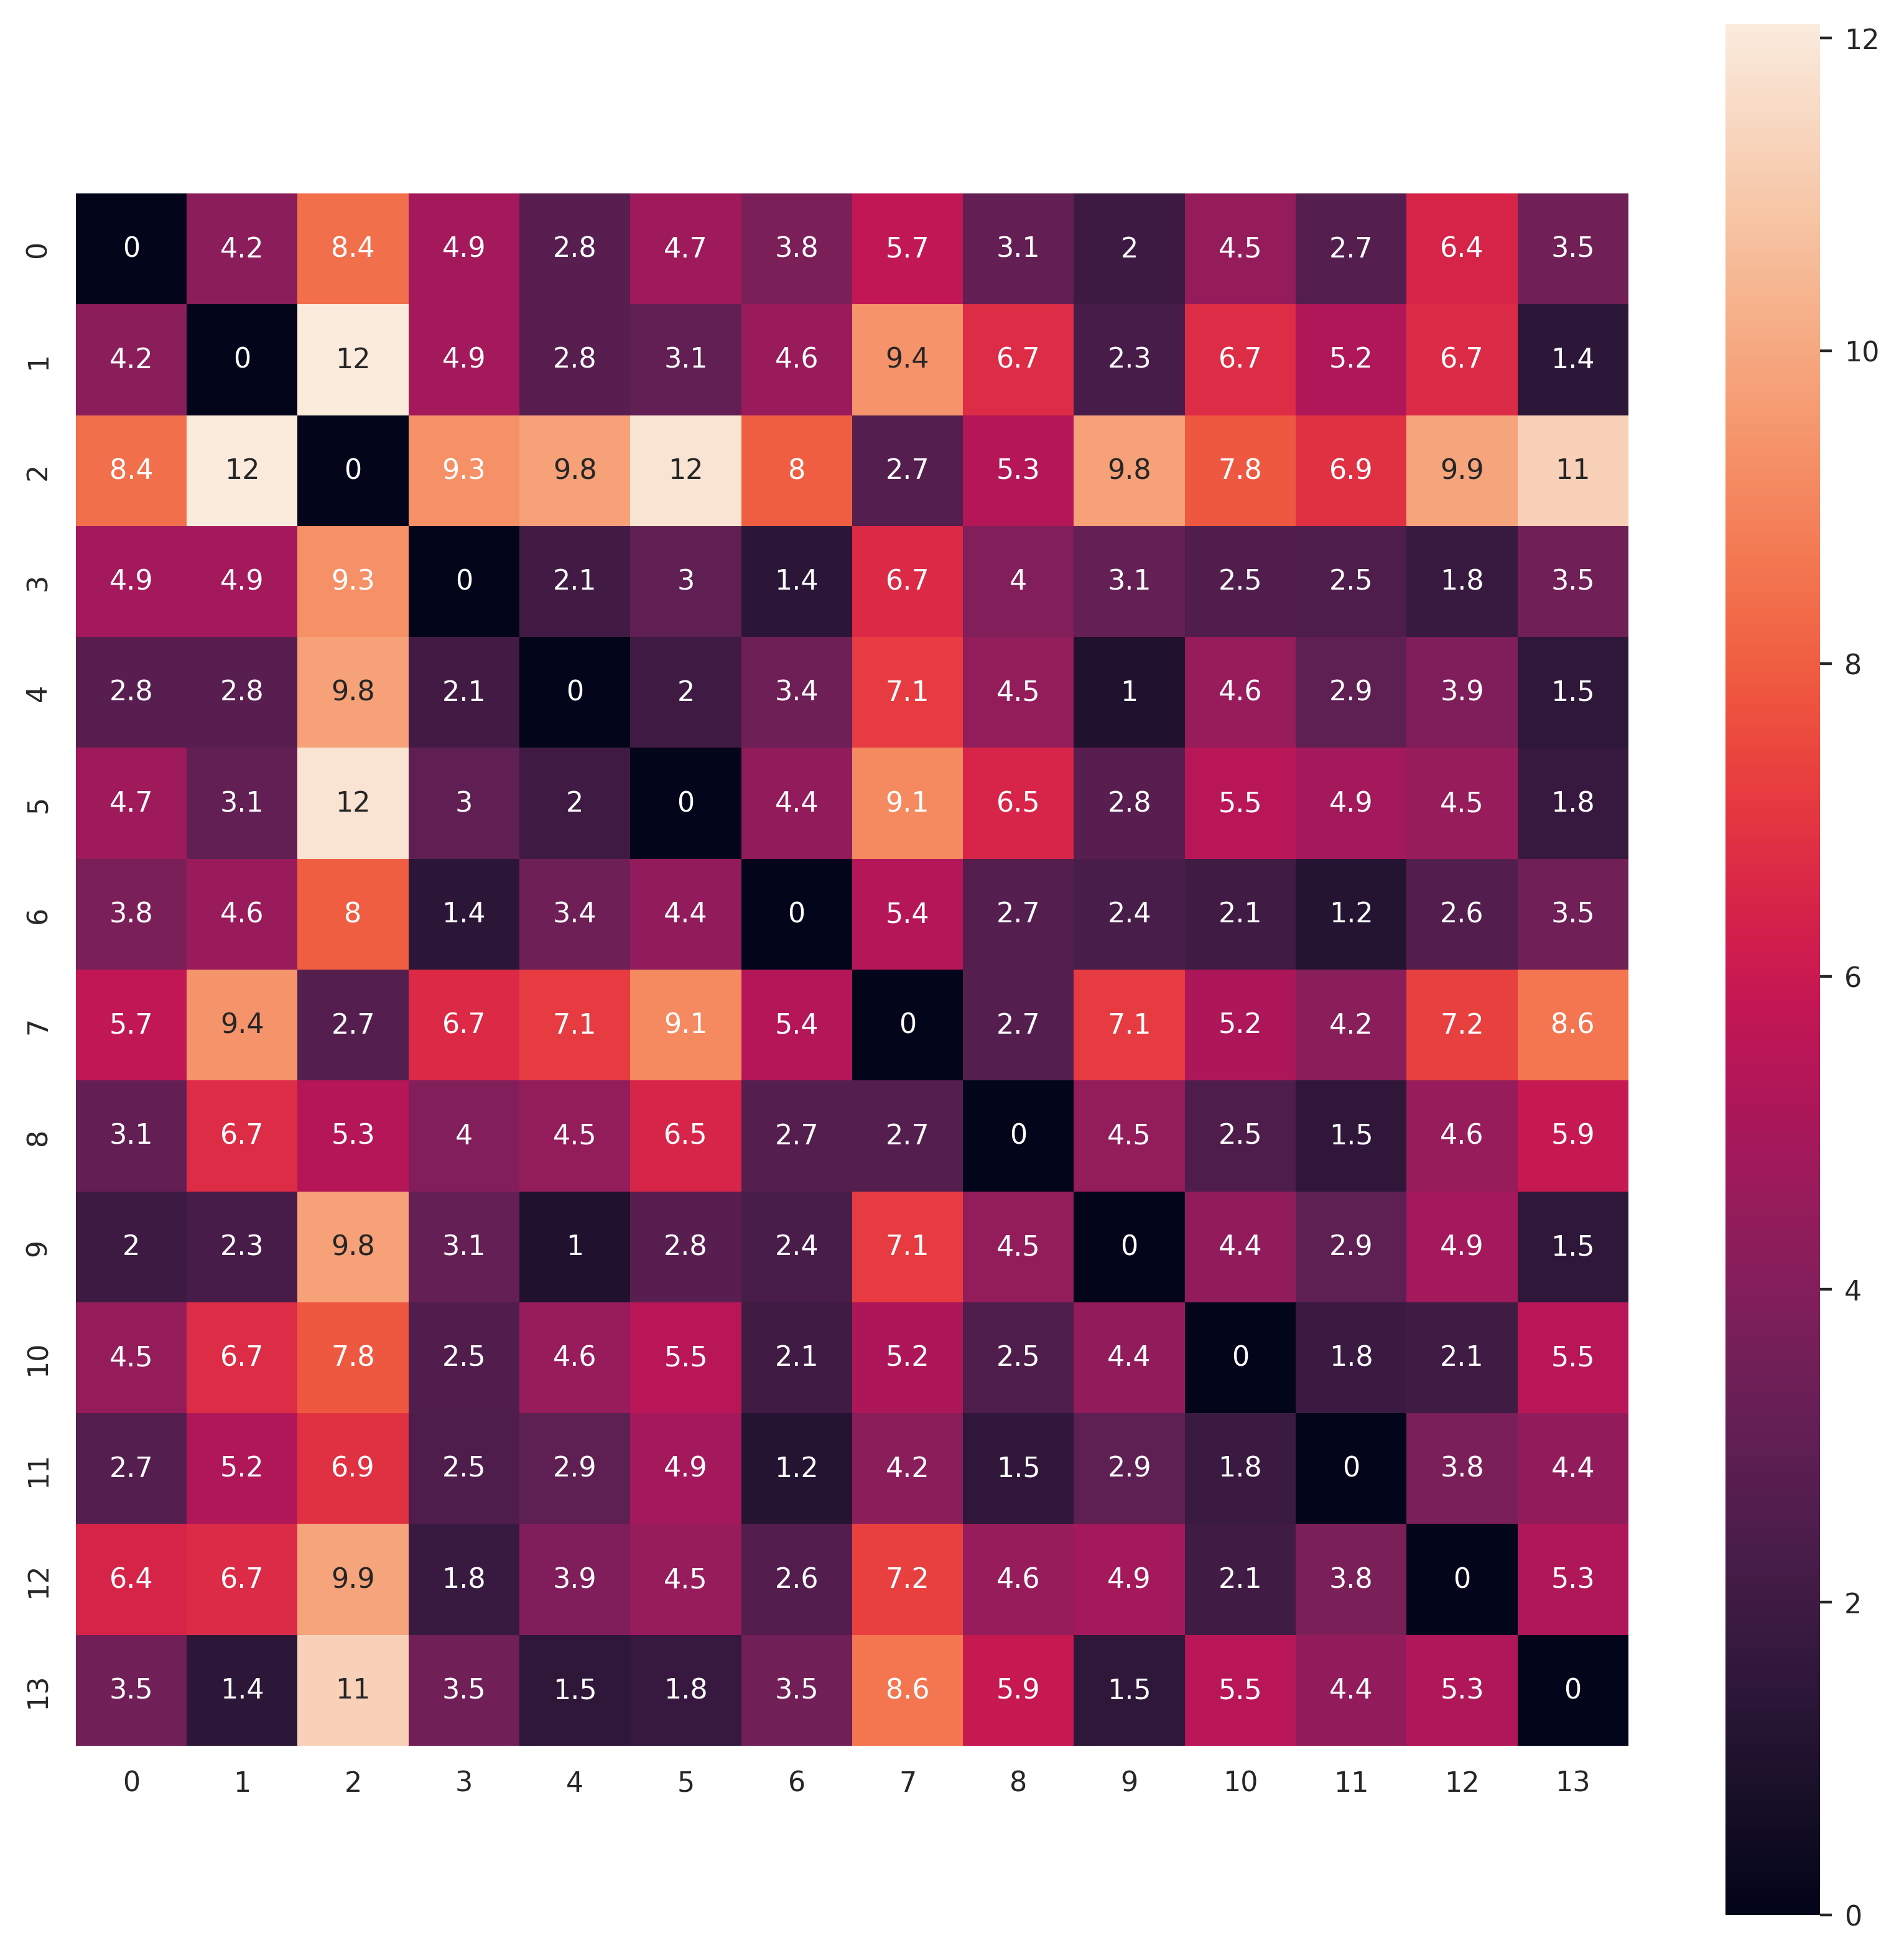

In [12]:
# plot the CGMGD
plot_matrix(gd)

### step 3 compute pairwise ME distance

In [13]:
# this step will add a X_ME_EMD_mat obsm to adata_phEMD
adata_phEMD = MED_phEMD_mp(
    adata.copy(),         # the used anndata
    GD_method=gd_method,  # use CGMGD as ground distance
    MED_knn=knn,          # ME size is set consistently as 10
    CT_obs=cls_key,       # use leiden cluster label
    ifspatialplot=False,  # do not show intermediate result plot
    OT_method='pyemd',    # use pyemd to compute EMD as ME distance
    ME_precompyted=True,  # use precomputed ME representation (already computed in step 1)
    GD_precomputed=True,  # use precomputed ground distance (already computed in step 2)
    mp=200                # multi process to accelerate the computation
)

EMD distance matrix cost 49.40083336830139s


In [14]:
# emd_distmat is the n*n pairwise ME distance
emd_distmat = (adata_phEMD.obsm['X_ME_EMD_mat'])
emd_distmat.shape

(3639, 3639)

### step 4 construct ME graph

In [15]:
# emd_distmat is computed by step 3
adata.obsp['ME_EMD_mat'] = emd_distmat

# number of neighbors is set to construct ME graph
n_neighbors=300

# compute the MEG, each node is a ME, edge is the connectivity. use similar manner as scanpy
sc.pp.neighbors( adata, n_neighbors=n_neighbors)
knn_indices, knn_dists, forest = sc.neighbors.compute_neighbors_umap( emd_distmat, n_neighbors=n_neighbors, metric='precomputed' )
adata.obsp['distances'], adata.obsp['connectivities'] = sc.neighbors._compute_connectivities_umap(
    knn_indices,
    knn_dists,
    adata.shape[0],
    n_neighbors, # change to neighbors you plan to use
)

# set the ME graph's associated information (connectivity matrix, distance matrix) to neighbors_EMD
adata.uns['neighbors_EMD'] = adata.uns['neighbors'].copy()

### step 5 spatial domain identification

#### step 5.1 use computed MEG as input of umap and leiden clustering

In [16]:
sc.tl.umap(adata,neighbors_key='neighbors_EMD')
adata.obsm['X_umap_EMD'] = adata.obsm['X_umap']
sc.tl.leiden(adata,neighbors_key='neighbors_EMD',key_added='leiden_EMD')

#### step 5.2 Merge regions according to MEG connectivities

In [17]:
sc.tl.paga(adata,groups='leiden_EMD',neighbors_key='neighbors_EMD')
merge_cls_paga(adata,thresh=0,min_cls=7,paga_plot=False)

merged 0 to 8
merged 1 to 10
merged 2 to 12
merged 3 to 4
merged 5 to 6
merged 6 to 7
merged 8 to 9


#### step 5.3 plot spatial domain

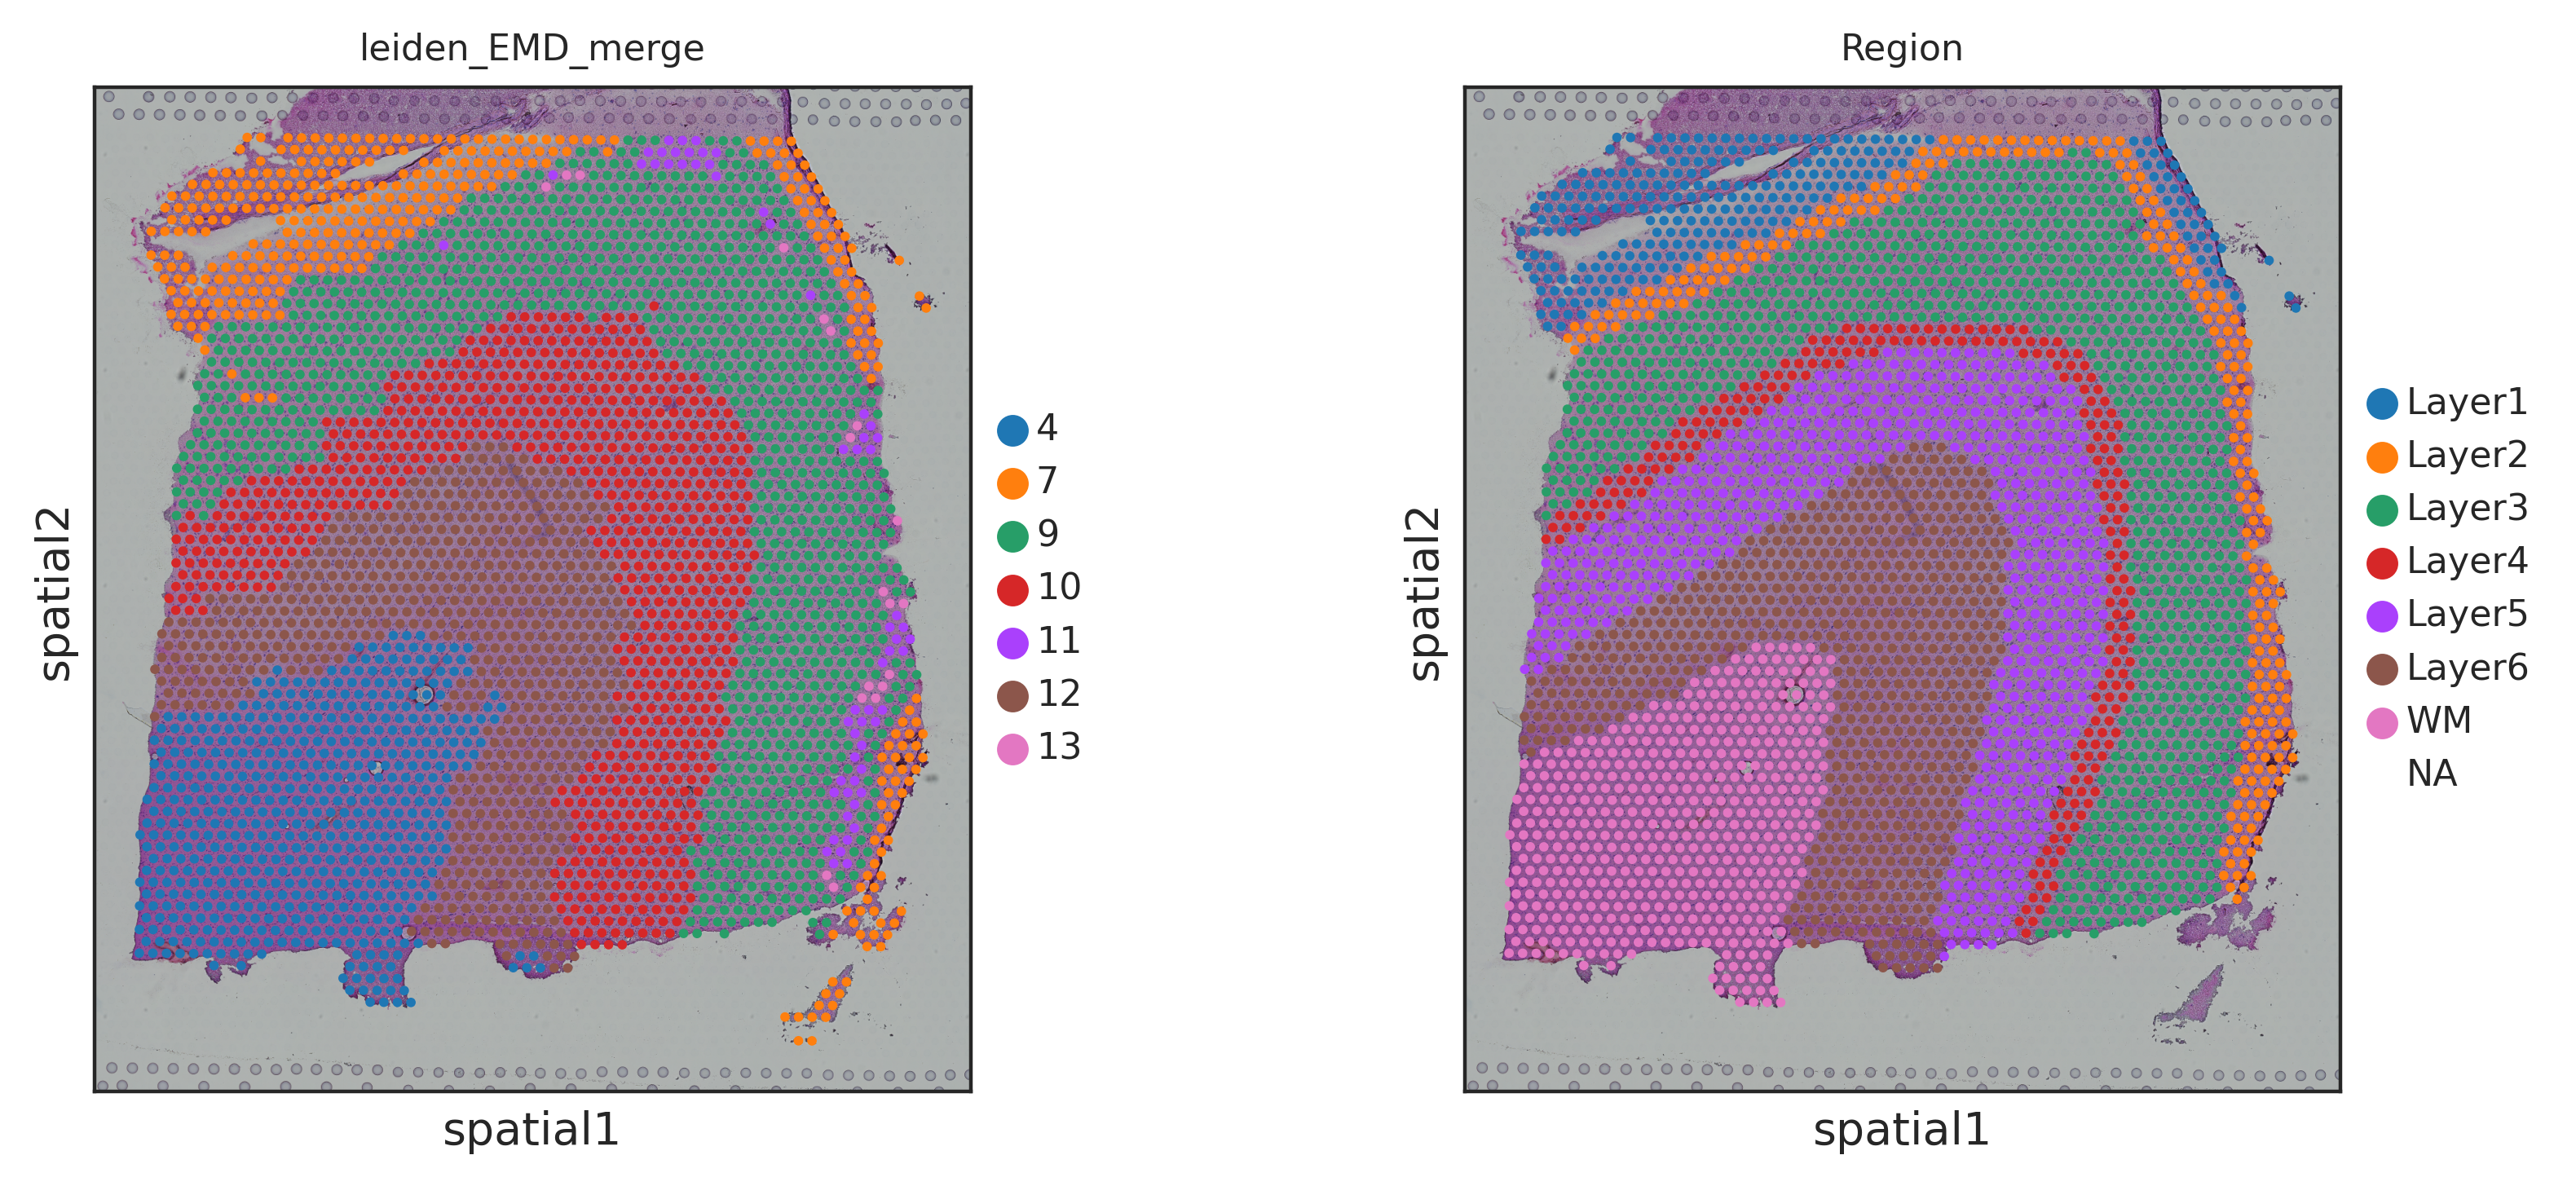

In [18]:
sc.pl.spatial(adata,color=['leiden_EMD_merge','Region'])


#### step 5.4 ARI 

In [19]:
# we remove the "Excluded" part
adata_valid = adata[np.logical_not(adata.obs['Region'].isna())]

cur_ari = adjusted_rand_score(adata_valid.obs['leiden_EMD_merge'],adata_valid.obs['Region'])
cur_ari

0.6713670762661105